# **Exploratory Data Analysis (EDL)** 

## Objectives

This notebook performs exploratory data analysis (EDA) on the processed dataset to better understand the engineered features created during the ETL stage. It combines statistical hypothesis testing and graphical exploration to identify meaningful patterns, validate assumptions, and confirm relationships relevant to fraud detection.

The insights from this analysis will provide a deeper understanding of feature significance, support model development, and inform the design of visual elements in the Power BI dashboard.

The tests for the following hypotheses compare two groups (fraudulent vs non-fraudulent transactions) using non-parametric data (data that is skewed, contains outliers, or is better described by ranks or medians rather than means). For this reason, I use the Mann–Whitney U test (which is ideally suited to this scenario):
- H1: Fraud increases with distance from home.
- H2: Fraud increases with distance from the last transaction.
- H3: Fraud increases with ratio to median purchase price.

In comparison, the Chi-square test of independence is used for the following hypotheses, as they involve categorical variables and assess whether there is a significant association between fraud occurrence and different transaction characteristics.

The Chi-square test is appropriate when comparing frequency counts across categories (e.g., online vs offline, chip used vs not used). It evaluates whether observed differences between groups are likely due to chance or reflect a genuine relationship.

Where Chi-square test results show contingency tables with very small expected cell counts (typically fewer than 5), the Fisher’s Exact Test is also conducted, as it provides a more reliable result for small samples.

Hypotheses tested with Chi-square (and Fisher's Exact if needed):
- H4: Online orders are more likely to be fraudulent.
- H5: Chip or PIN use reduces fraud likelihood.
- H6: Fraud likelihood varies by repeat retailer.
- H8: Fraud likelihood depends on the combination of online order and chip use (interaction effect).

**Note:**
- H7: Threshold tuning will be explored in the modelling notebook using Precision–Recall curve analysis to illustrate how different cost trade-offs affect performance. This step demonstrates the balance between detecting more fraud and reducing false positives, but it is not a statistical hypothesis test.

## Inputs
- Processed dataset data/processed/card_transdata_processed.csv produced from ETL (which was derived from 100k stratified sample)

## Outputs
- Statistical test results (Mann–Whitney U and Chi-square).
- Visualisations showing feature distributions and comparisons between fraud and non-fraud transactions.
- Business insights highlighting key fraud detection patterns.
- Results from this notebook will also inform:
    - Modelling (feature selection and variable importance).
    - Power BI Dashboard Reports

---

# Change working directory

I need to change the working directory from the current folder to its parent folder (required because the notebook is being run from inside the jupyter notebooks subfolder). In the code below, I change the working directory from its current folder to its parent folder.  
* I access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\DA_Capstone\\Credit-Card-Fraud-Analysis'

# Section 1: Libraries for Visualisations, Data Check and Class Distribution Check

In this first section, the required data analysis and visualisation libraries are loaded to support statistical testing and exploratory analysis.

Quick checks are performed to ensure the processed dataset produced in the ETL stage has loaded correctly and matches the expected structure (I expect to see extra engineered columns whilst the fraud class distribution should remain the same):
- Load the processed dataset from data/processed/card_transdata_processed.csv
- Conduct basic shape and structure checks
- Verify data loaded correctly before proceeding to hypothesis testing
- Verify fraud rate matches the rate expected from sample metadata file (8.74%)
- Check imbalance ratio 

**Results:**
- Dataframe loads and shape as expected: 100,000 rows × 17 columns
- First 5 rows load and display as expected
- Fraud rate is 8.74% and this matches the rate in the sample metadata file
- Imbalance ratio is 1:10.4 (non-fraud to fraud)

Results confirm the processed file matches expected structure and is ready for exploratory analysis.


Section 1 content

In [4]:
# Import Data analysis and visualisation libraries for EDA
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for basic plotting
import seaborn as sns # for enhanced visualisations
from scipy import stats # Statistical libraries
from scipy.stats import chi2_contingency # Chi-squared test
import numpy as np # for numerical operations
import plotly.express as px # for interactive visualisations

# Load processed dataset (output from 100k 01_ETL.ipynb) and check structure
df = pd.read_csv("data/processed/card_transdata_processed.csv")

df.shape # display the shape of the dataframe

(100000, 17)

In [5]:
df.head() # display the first 5 rows of the dataframe to check data loaded correctly

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud,log_distance_from_home,log_distance_from_last_transaction,log_ratio_to_median_purchase_price,log_distance_from_home_bin,log_purchase_price_bin,log_distance_from_last_transaction_bin,online_high_distance,online_chip_category,online_and_chip
0,19.179396,0.178758,2.979353,1,0,0,1,0,3.004662,0.164461,1.381119,3,4,0,1,online_no_chip,0
1,47.192898,1.224832,0.293538,1,1,0,1,0,3.875212,0.799681,0.257381,4,0,2,1,online_with_chip,1
2,54.389043,5.290910,4.492304,1,1,0,0,0,4.014382,1.839106,1.703348,4,4,4,0,offline_with_chip,0
3,3.129745,0.607212,0.357527,1,0,0,1,0,1.418216,0.474501,0.305665,1,0,1,0,online_no_chip,0
4,0.925275,2.238057,0.684942,0,0,0,0,0,0.655069,1.174974,0.521731,0,1,3,0,offline_no_chip,0


In [6]:

# Display fraud rate and counts clearly
fraud_count = int(df['fraud'].sum()) # count the number of fraud cases
fraud_rate = df['fraud'].mean() # calculate the fraud rate
total_rows = df.shape[0] # get the total number of transactions
print(f"Fraud rate: {fraud_rate:.2%} ({fraud_count} fraud cases out of {total_rows} total transactions)") # display fraud rate and counts clearly

# Verify against expected rate from sample_log.json
expected_fraud_rate = 0.0874  # 8.74% from stratified sampling
rate_difference = abs(fraud_rate - expected_fraud_rate) # calculate difference

if rate_difference < 0.0001:  # allows for tiny floating point difference
    print(f"Class balance matches expected rate ({expected_fraud_rate:.2%})") # print confirmation if rates match
else:
    print(f"Mismatch Fraud rate {fraud_rate:.4%} differs from expected {expected_fraud_rate:.2%}")

# Calculate imbalance ratio
imbalance_ratio = (1 - fraud_rate) / fraud_rate # ratio of non-fraud to fraud cases
print(f"Imbalance ratio is: 1:{imbalance_ratio:.1f} (non-fraud to fraud)") # display imbalance ratio

Fraud rate: 8.74% (8740 fraud cases out of 100000 total transactions)
Class balance matches expected rate (8.74%)
Imbalance ratio is: 1:10.4 (non-fraud to fraud)


**Class Distribution Additional Checks**

The proportion of fraudulent and non-fraudulent transactions is visualised further here confirm the class balance.The dataset shows 8.7 % fraud and 91.3 % non-fraud, reflecting the expected imbalance from the full dataset.

Two visuals are provided side by side for clarity:
- A bar chart showing transaction counts by class.
- A pie chart illustrating percentage distribution.

Matplotlib was used to create both a bar chart and a pie chart showing the distribution of fraudulent and non-fraudulent transactions.
Matplotlib provides fine control over layout and styling, making it ideal for simple visual checks like class balance. 

This confirms that the sampling and processing steps preserved the original class proportions, and that fraud remains a minority class for all subsequent analysis and modelling.

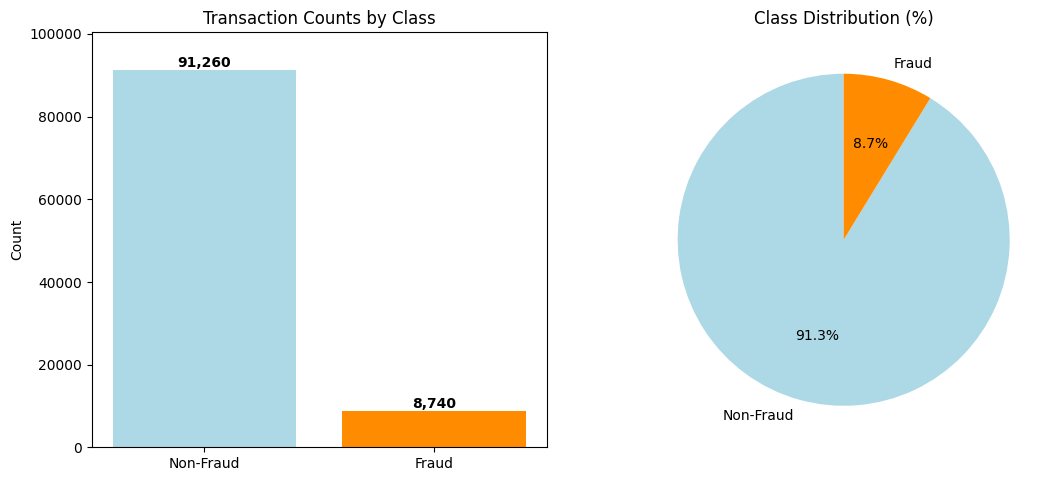

Class imbalance: 8.74% fraud, 91.26% non-fraud
Imbalance ratio: 1:10


In [7]:
# Visualise overall fraud class balance (Matplotlib)
fraud_counts = df['fraud'].value_counts() # Count of each class
fraud_pct = df['fraud'].value_counts(normalize=True) # Percentage of each class

fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # 1 row, 2 colmumns for side-by-side plots

# Fraud Count Bar Plot
axes[0].bar(['Non-Fraud', 'Fraud'], fraud_counts.values, color=['lightblue', 'darkorange']) # bar chart
axes[0].set_ylabel('Count') # y-axis label
axes[0].set_title('Transaction Counts by Class') # title
axes[0].set_ylim(0, fraud_counts.max() * 1.1) # set y-axis limit
for i, v in enumerate(fraud_counts.values): # loop through bars
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold') # value labels

# Percentage Pie Plot
axes[1].pie(fraud_pct.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%',  # display percentages
            colors=['lightblue', 'darkorange'], startangle=90) # pie chart
axes[1].set_title('Class Distribution (%)') # title

plt.tight_layout(pad=5.0) # adjust layout
plt.show() # display plot

print(f"Class imbalance: {fraud_pct[1]:.2%} fraud, {fraud_pct[0]:.2%} non-fraud") # print class percentages
print(f"Imbalance ratio: 1:{int(fraud_pct[0]/fraud_pct[1])}") # print imbalance ratio

Section 2 content

---

# Conclusion and Next Steps